Find this project in [Github: UberHowley/MOOC-File-Processing](https://github.com/UberHowley/mooc-file-processing)

---

# Python Processing of the QuickHelper System Logfiles
In Massive Open Online Courses (MOOCs), it is common for students to use the discussion forums to seek help, but oftentimes their discussion thread gets buried under hundreds of other threads resulting in their question never being answered. Our QuickHelper system uses a social recommendation algorithm to recommend three qualified peers that the student can invite to their public discussion thread, but **how do we present the selected peers in such a way as to increase the number of helpers selected**? 

## Research Questions
Our QuickHelper system was designed to advise students on which peers they might want to help them, but also to answer  theory-based questions about student motivation and decision-making in the face of common interactional archetypes employed in MOOCs. This yielded the following research questions:
1. Does the presence of Help Giver badges increase the number of helpers students invite to their question thread? (*isBadgeCondition --> numHelpersSelected*)
  1. Does the number of stars shown on the badge impact whether or not the peer is selected?
2. Does showing expertise information about potential helpers increase the number of helpers the student invites to her question thread? (*sentenceType --> numHelpersSelected*)
  1. Does the number of weeks joined or the topic knowledge match percentage increase the likelihood of a peer being selected?
3. Does knowing your selected helpers will be up or downvoting on the quality of the question negatively impact the number of helpers invited to the question thread? (*isVotingCondition --> numHelpersSelected*)
4. Do the badges or expertise sentences lessen the negative effects of the up and down voting?
I discuss these questions and the experimental set up more in-depth [here](http://www.irishowley.com/website/pMOOChelpers.html).

## The QuickHelper System
The QuickHelper system process is shown in the figure below. (1) The student clicks the QuickHelper button and writes her question. (2) The question posts to the public discussion forum. (3) Simultaneously, the message board post is submitted to the QuickHelper system. (4) The QuickHelper system selects 3 qualified potential helpers based on information it knows about the students and the provided question. (5) The QuickHelper system shows the student the 3 selected potential helpers. (6) The student picks 0-3 helpers. (7) The system emails the selected helpers with a link to the discussion forum post. (8) [not shown] The helpers may or may not click the link from the email.
![The QuickHelper system process](http://www.irishowley.com/website/images/proj_mooc_quickhelper.jpg)
When designing the QuickHelper system, we had to take into consideration our logging needs with respect to our research questions. There are three separate moments of timing in our system, yielding at least four logs: (1) At step 4 where the system selects helpers, (2) step 5 where the system presents the helpers to the student. (3) At step 6 where the students picks 0-3 helpers. (4) Step 8 where the helpers click the link they receive via email and potentially up/downvote the question. In this analysis, we're mostly concerned with the first three logs: `user.log, helper.log, and selection.log`. Each line in `user.log` represents one question/forum message (i.e., one usage of the QuickHelper system). One line in `user.log` has three corresponding lines in `helper.log`: one for each potential helper shown to the student. One line in `selection.log` represents a single helper that was selected.

## Processing Logfiles
Processing the logfiles removes the metadata and major inconsistencies in the raw data in order to prepare it for analysis by external programs. There were (1) various errors in the logging software (i.e., mysterious duplicates whose instance IDs were different, extra columns on some lines with a URL), (2) general cleaning that was necessary (i.e., removing test entries, removing entries from our researchers, removing entries outside the course date range), and (3) more complicated post-processing that was necessary (i.e., cross-referencing and compiling values from one logfile into another). My `logfileMOOC.py` script compiles and resolves all the log inter-dependencies, as shown below.:
![The QuickHelper logfile dependencies](http://www.irishowley.com/website/images/proj_moocLogDependencies.jpg)

### QuickHelper Version
In the initial two weeks of the course, the QuickHelper system did not have enough information to be able to recommend helpers. This 'cold start' required the implementation of two versions of the system: the `TA` version, and the `student` version. In the TA version, all selected helpers were actually volunteer teaching assistants for the course. Assignment to the badge and voting conditions remained the same, but all helpers would be shown with 4 stars on their badge, if in the `isBadgeCondition`. The TA version did not have anyone in the anonymized `isUsernameCondition` nor did the `isIrrelevantSentence` condition exist: all TAs were shown with the same sentence.

### Removing Duplicates ###
The 'mysterious duplicates' were an interesting side issue. Previously, we had been removing what appeared to be duplicate instances from the log manually. The issue was that these duplicates would have the same author, question title/body, and date, but everything else would be different. I created a duplicate key for each QuickHelper instance using the author, question title, and date. The duplicate key was used in a dictionary to map to a list of all the duplicates that shared that key. To determine which duplicate was the instance the user actually saw, I iterated through each list of duplicates and found the one with entries in the selection.log (i.e., the user only selected helpers from one instance, the real one). If there was no helper was selected, I removed all information that the duplicates did not share. By random chance, some of the duplicates would share conditions or helpers shown. This did result in some columns missing data for some entries in the user and helper logfiles, but there was no other way to determine which duplicate was the instance seen by the user.

In [ ]:
def remove_duplicates():
    """
    Remove duplicates from our list of instances, based on whatever key was used in duplicate_instances
    :return: A list of QHInstances with all duplicates removed
    """
    for duplicate_key in instances_by_dupkey:  # iterate through each key in our duplicate-arranged list
        selected_dup = None  # instance with a selection (the one shown)
        for dup in instances_by_dupkey[duplicate_key]:  # for each instance object in these duplicates
            num_helpers = dict_num_helpers.get(getattr(dup, 'instance_id'), 0)
            if num_helpers > 0:  # If it has helpers selected, it's the one
                selected_dup = dup
                setattr(dup, 'num_helpers_selected', num_helpers)
        if selected_dup is None:
                selected_dup = create_new_duplicate(instances_by_dupkey[duplicate_key])  # Clear out non-matching condition variables
        list_no_duplicates.append(selected_dup)  # Record selected_dup as our correct one
        # Store this sentence, too (for topic modeling)
        list_sentences.append(ldat.clean_string(" ".join([getattr(selected_dup, 'question_title', ''), ' '+getattr(selected_dup,'question_body','')])))

        if len(instances_by_dupkey[duplicate_key]) > 1:  # counting our duplicates
            global count_repeat
            count_repeat += len(instances_by_dupkey[duplicate_key])-1
    return list_no_duplicates

See a sample of two (simulated) lines from the outputted logfile below: the bottom line being produced from several duplicates that shared helper ID numbers, isVotingCondition, among other expected features (question title, question body, author, date, etc.). Condition assignments that did not match across all duplicates are removed.

<table><tr><td>instanceID</td><td>version</td><td>isBadgeCond</td><td>isIrrelevantSentence</td><td>isVotingCond</td><td>isNameCond</td><td>helper0</td><td>helper1</td><td>helper2</td><td>numHelpersSelected</td></tr>
<tr><td>1234...7890</td><td>student</td><td>n</td><td>n</td><td>y</td><td>y</td><td>135790</td><td>246802</td><td>998877</td><td>0</td></tr>
<tr><td>0987...4321</td><td>student</td><td> </td><td> </td><td>y</td><td> </td><td>235689</td><td>986532</td><td>555123</td><td>0</td></tr>
</table>

## Statistical Analysis
I used the pandas and statsmodels libraries to run descriptive statistics, generate plots to better understand the data, and answer our research questions (from above). The main effects of interest were the categorical condition variables (i.e., `isBadgeCondition, isSentenceCondition, isVotingCondition`) and the scalar dependent variable, `number of helpers selected`.

In [31]:
%matplotlib inline
import utilsMOOC as utils  # contains all the constants we need
import pandas as pd
import matplotlib.pyplot as plt
data = pd.io.parsers.read_csv("user.csv", encoding="utf-8-sig")

conditions = [utils.COL_VERSION, utils.COL_BADGE, utils.COL_SENTENCE_TYPE, utils.COL_VOTING]  # all our categorical IVs of interest
outcome = utils.COL_NUMHELPERS

### Descriptive Statistics
Descriptive statistics showed that 75% of users selected zero helpers, with 3 and 1 helpers being seelcted the second and third most popular choice, respectively.

In [32]:
# Min & Max numHelpers should be 0-3
df = data[[outcome]]
df.describe()

,numHelpersSelected
count,159.000000
mean,0.779874
std,1.156423
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,3.000000


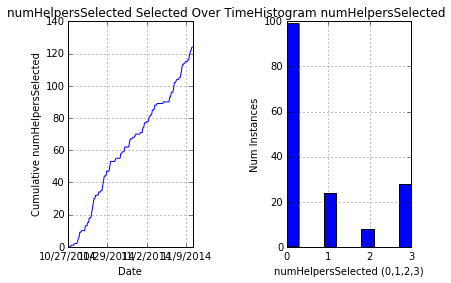

In [35]:
# Look at a descriptive plot of our outcome variable
helpers_by_date = data[outcome]
helpers_by_date.index = data[utils.COL_DATE]
helpers_by_date = helpers_by_date.cumsum()

# num helpers selected over time
# This plot would be more useful as a debugging tool when the system is live.
# It shows how many helpers are selected over time.
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1 = helpers_by_date.plot(title=outcome+" Selected Over Time")
ax1.locator_params(axis='x', nbins=6)
ax1.set_xlabel(utils.COL_DATE)
ax1.set_ylabel("Cumulative "+outcome)

# histogram of num helpers
# Here we see that 
ax2 = fig.add_subplot(122)
helpers_hist = data[outcome]
ax2 = helpers_hist.plot(kind='hist', title="Histogram "+outcome, by=outcome)
ax2.locator_params(axis='x', nbins=4)
ax2.set_xlabel(outcome+" (0,1,2,3)")
ax2.set_ylabel("Num Instances")

fig.tight_layout()
plt.show()

When looking at the independent variables, we see that random assignment to all conditions was mostly successful (approximately even distribution to all conditions), except in the case of 'version', but this was not random assignment. This code also output the mean number of helpers selected in each condition and we can start to identify an interest pattern in the `sentenceCondition` (i.e., more helpers being selected in `relevant` sentence condition) and the `isVotingCondition` (i.e., more helpers being selected when there is no voting). Both of these trends support our research questions.

In [36]:
df = data[conditions+[outcome]]
for cond in conditions:
    print(pd.concat([df.groupby(cond)[cond].count(), df.groupby(cond)[outcome].mean()], axis=1))

         version  numHelpersSelected
version                             
TA            45            0.844444
student      114            0.754386
                  isBadgeCondition  numHelpersSelected
isBadgeCondition                                      
n                               70            0.928571
y                               73            0.808219
                   sentenceCondition  numHelpersSelected
sentenceCondition                                       
TA                                45            0.844444
irrelevant                        45            0.733333
relevant                          50            1.060000
                   isVotingCondition  numHelpersSelected
isVotingCondition                                       
n                                 69            1.115942
y                                 67            0.701493


### Answering Our Research Questions
The research questions require a bit of statistics to answer. In the case of a single factor with two levels we use a t-test to determine if the independent variable in question has a significant effect on the outcome variable. In the case of a single factor with more than two levels, we use a one-way Analysis of Variance (ANOVA). With more than one factor we use a two-way ANOVA. These are all essentially similar linear models (ordinary least squares), with slightly different equations or statistics for determining significance. 

#### Does the presence of Help Giver badges increase the number of helpers students invite to their question thread? 
*(isBadgeCondition --> numHelpersSelected)*

To answer this question, we run a t-test and find that the p-value is 0.54, which is not less than 0.05. isBadgeCondition does not have a significant effect on number of helpers selected (i.e., any differences between the two badge conditions are likely due to random variance).

(-0.60413902721148727, 0.54672203662900154, 141.0)
(t-stat, p-value, df)


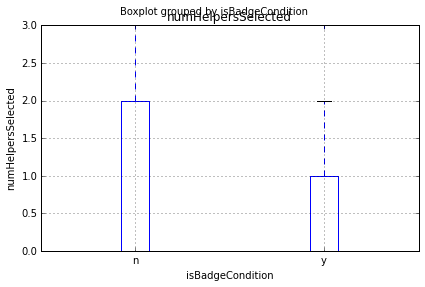

In [47]:
from statsmodels.stats.weightstats import ttest_ind
cond = utils.COL_BADGE
df = data[[cond, outcome]].dropna()

cat1 = df[df[cond] == 'y'][outcome]
cat2 = df[df[cond] == 'n'][outcome]

print(ttest_ind(cat1, cat2))  # returns t-stat, p-value, and degrees of freedom
print("(t-stat, p-value, df)")

# boxplot
fig = plt.figure()
ax = fig.add_subplot(111)
ax = df.boxplot(outcome, cond, ax=plt.gca())
ax.set_xlabel(cond)
ax.set_ylabel(outcome)
fig.tight_layout()

#### Does showing expertise information about potential helpers increase the number of helpers the student invites to her question thread? 
*(sentenceType --> numHelpersSelected)*

We run a one-way ANOVA to answer this question, and the p-value of 0.4 is not significant. 

                       df      sum_sq   mean_sq         F    PR(>F)
C(sentenceCondition)    2    2.640317  1.320159  0.924977  0.399003
Residual              137  195.531111  1.427234       NaN       NaN
                            OLS Regression Results                            
Dep. Variable:     numHelpersSelected   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9250
Date:                Sun, 26 Apr 2015   Prob (F-statistic):              0.399
Time:                        16:49:26   Log-Likelihood:                -222.04
No. Observations:                 140   AIC:                             450.1
Df Residuals:                     137   BIC:                             458.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
      

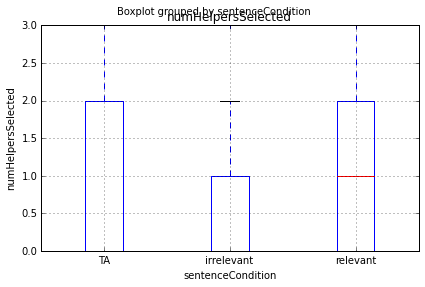

In [48]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
cond = utils.COL_SENTENCE_TYPE
df = data[[cond, outcome]].dropna()

cond_lm = ols(outcome + " ~ C(" + cond + ")", data=df).fit()
anova_table = anova_lm(cond_lm)
print(anova_table)
print(cond_lm.summary())

# boxplot
fig = plt.figure()
ax = fig.add_subplot(111)
ax = df.boxplot(outcome, cond, ax=plt.gca())
ax.set_xlabel(cond)
ax.set_ylabel(outcome)
fig.tight_layout()

When we remove the `TA` version from our analysis, we see that irrelevant/relevant sentence still has no significant effect on number of helpers selected (p = 0.19).

(-1.32629465054304, 0.18799008284698659, 93.0)
(t-stat, p-value, df)


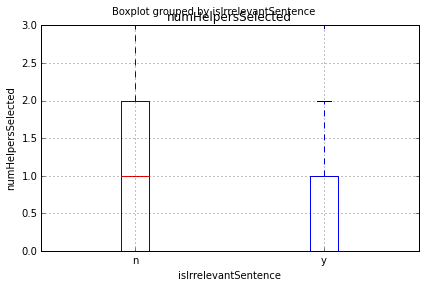

In [49]:
cond = utils.COL_IRRELEVANT
df = data[[cond, outcome]].dropna()

cat1 = df[df[cond] == 'y'][outcome]
cat2 = df[df[cond] == 'n'][outcome]

print(ttest_ind(cat1, cat2))  # returns t-stat, p-value, and degrees of freedom
print("(t-stat, p-value, df)")

# boxplot
fig = plt.figure()
ax = fig.add_subplot(111)
ax = df.boxplot(outcome, cond, ax=plt.gca())
ax.set_xlabel(cond)
ax.set_ylabel(outcome)
fig.tight_layout()

#### Does knowing your selected helpers will be up or downvoting on the quality of the question negatively impact the number of helpers invited to the question thread? 
*(isVotingCondition --> numHelpersSelected)*

The voting condition does appear to have a sifniciant effect on number of helpers selected, with a p-value of 0.04. The boxplot shows us that help-seekers in the voting condition (y) select less helpers than those in the not-voting condition (n).

(-2.034080239642635, 0.043916902726052164, 134.0)
(t-stat, p-value, df)


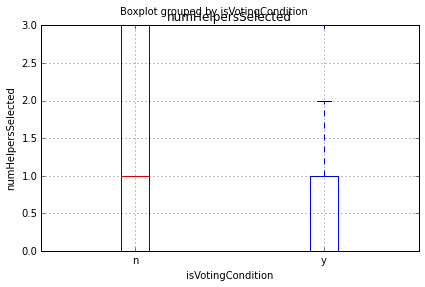

In [50]:
cond = utils.COL_VOTING
df = data[[cond, outcome]].dropna()

cat1 = df[df[cond] == 'y'][outcome]
cat2 = df[df[cond] == 'n'][outcome]

print(ttest_ind(cat1, cat2))  # returns t-stat, p-value, and degrees of freedom
print("(t-stat, p-value, df)")

# boxplot
fig = plt.figure()
ax = fig.add_subplot(111)
ax = df.boxplot(outcome, cond, ax=plt.gca())
ax.set_xlabel(cond)
ax.set_ylabel(outcome)
fig.tight_layout()

#### Interaction Analyses
Since the conditions discussed in this analysis were being shown simultaneously, it is important to examine the interaction between variables.

##### Do the badges lessen the negative effects of the up and down voting?
*isBadgeCondition X isVotingCondition --> numHelpersSelected*

The OLS output suggests a marginal trend (p = 0.07, which is less than 0.1) for this interaction.

In [78]:
col_names = [utils.COL_BADGE, utils.COL_VOTING, utils.COL_NUMHELPERS]
factor_groups = data[col_names].dropna()

formula = col_names[2] + " ~ C(" + col_names[0] + ") + C(" + col_names[1] + ")"
formula_interaction = formula.replace('+', '*')
interaction_lm = ols(formula, data=factor_groups).fit()  # linear model
print(interaction_lm.summary())

print("==============================")
print("- " + col_names[2] + " = " + col_names[0] + " * " + col_names[1] + " Interaction -")
print(anova_lm(ols(formula_interaction, data=factor_groups).fit(), interaction_lm))

print("==============================")
# TODO: figure out what these are doing
print("- " + col_names[2] + " = " + col_names[0] + " ANOVA -")
print(anova_lm(ols(col_names[2] + " ~ C(" + col_names[0] + ")", data=factor_groups).fit(), ols(col_names[2] +" ~ C("+col_names[0]+") + C(" + col_names[1]+", Sum)", data=factor_groups).fit()))

print("==============================")
print("- " + col_names[2] + " = " + col_names[1] + " ANOVA -")
print(anova_lm(ols(col_names[2] + " ~ C(" + col_names[1] + ")", data=factor_groups).fit(), ols(col_names[2] +" ~ C("+col_names[0]+") + C(" + col_names[1]+", Sum)", data=factor_groups).fit()))

                            OLS Regression Results                            
Dep. Variable:     numHelpersSelected   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.692
Date:                Sun, 26 Apr 2015   Prob (F-statistic):             0.0715
Time:                        17:15:10   Log-Likelihood:                -211.97
No. Observations:                 134   AIC:                             429.9
Df Residuals:                     131   BIC:                             438.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept             

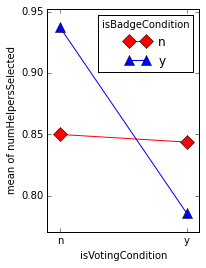

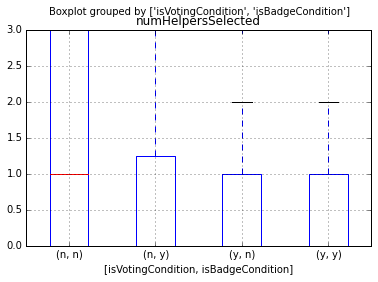

In [77]:
from statsmodels.graphics.api import interaction_plot
fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1 = interaction_plot(factor_groups[col_names[1]], factor_groups[col_names[0]], factor_groups[col_names[2]], colors=['red', 'blue'], markers=['D', '^'], ms=10, ax=plt.gca())

ax2 = fig.add_subplot(121)
ax2 = factor_groups.boxplot(return_type='axes', column=col_names[2], by=[col_names[1], col_names[0]])

##### Do the expertise sentences lessen the negative effects of the up and down voting?
*sentenceType X isVotingCondition --> numHelpersSelected*

The OLS output suggests another marginal effect of this interaction on number of helpers selected (p = 0.06). Our interaction plots show that when up/downvoting is not used, all three sentence types are rather indistinguishable. However, when up and down voting is used, a relevant expertise sentence appears to reduce the negative effect of voting, while an irrelevant expertise sentence does not increase the number of helpers selected.

TODO: Statistical tests to determine which groups a distinguishable from each other.

In [70]:
col_names = [utils.COL_SENTENCE_TYPE, utils.COL_VOTING, utils.COL_NUMHELPERS]
factor_groups = data[col_names].dropna()

formula = col_names[2] + " ~ C(" + col_names[0] + ") + C(" + col_names[1] + ")"
formula_interaction = formula.replace('+', '*')
interaction_lm = ols(formula, data=factor_groups).fit()  # linear model
print(interaction_lm.summary())

print("==============================")
print("- " + col_names[2] + " = " + col_names[0] + " * " + col_names[1] + " Interaction -")
print(anova_lm(ols(formula_interaction, data=factor_groups).fit(), interaction_lm))

print("==============================")
print("- " + col_names[2] + " = " + col_names[0] + " + " + col_names[1] + " ANOVA -")
print(anova_lm(ols(col_names[2] + " ~ C(" + col_names[0] + ")", data=factor_groups).fit(), ols(col_names[2] +" ~ C("+col_names[0]+") + C(" + col_names[1]+", Sum)", data=factor_groups).fit()))

print("==============================")
print("- " + col_names[2] + " = " + col_names[1] + " + " + col_names[0] + " ANOVA -")
print(anova_lm(ols(col_names[2] + " ~ C(" + col_names[1] + ")", data=factor_groups).fit(), ols(col_names[2] +" ~ C("+col_names[0]+") + C(" + col_names[1]+", Sum)", data=factor_groups).fit()))

                            OLS Regression Results                            
Dep. Variable:     numHelpersSelected   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     2.499
Date:                Sun, 26 Apr 2015   Prob (F-statistic):             0.0624
Time:                        17:05:37   Log-Likelihood:                -210.91
No. Observations:                 134   AIC:                             429.8
Df Residuals:                     130   BIC:                             441.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Inte

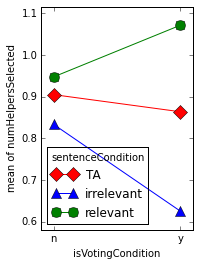

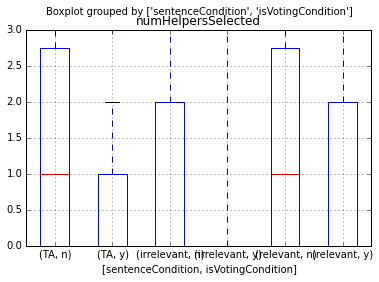

In [73]:
fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1 = interaction_plot(factor_groups[col_names[1]], factor_groups[col_names[0]], factor_groups[col_names[2]], colors=['red', 'blue', 'green'], markers=['D', '^', 'o'], ms=10, ax=plt.gca())

ax2 = fig.add_subplot(121)
ax2 = factor_groups.boxplot(return_type='axes', column=col_names[2], by=[col_names[0], col_names[1]])

##### Do badge and sentence type interact?
*isBadgeCondition X sentenceType --> numHelpersSelected*

While not part of our original research questions, it is important to include this last comparison of conditions. With a p-value of 0.399, there does not appear to be any interaction between badge and sentence type on number of helpers selected.

In [61]:
col_names = [utils.COL_BADGE, utils.COL_SENTENCE_TYPE, utils.COL_NUMHELPERS]
factor_groups = data[col_names].dropna()

formula = col_names[2] + " ~ C(" + col_names[0] + ") + C(" + col_names[1] + ")"
formula_interaction = formula.replace('+', '*')
interaction_lm = ols(formula, data=factor_groups).fit()  # linear model
print(interaction_lm.summary())

print("==============================")
print("- " + col_names[2] + " = " + col_names[0] + " * " + col_names[1] + " Interaction -")
print(anova_lm(ols(formula_interaction, data=factor_groups).fit(), interaction_lm))

print("==============================")
print("- " + col_names[2] + " = " + col_names[0] + " + " + col_names[1] + " ANOVA -")
print(anova_lm(ols(col_names[2] + " ~ C(" + col_names[0] + ")", data=factor_groups).fit(), ols(col_names[2] +" ~ C("+col_names[0]+") + C(" + col_names[1]+", Sum)", data=factor_groups).fit()))

print("==============================")
print("- " + col_names[2] + " = " + col_names[1] + " + " + col_names[0] + " ANOVA -")
print(anova_lm(ols(col_names[2] + " ~ C(" + col_names[1] + ")", data=factor_groups).fit(), ols(col_names[2] +" ~ C("+col_names[0]+") + C(" + col_names[1]+", Sum)", data=factor_groups).fit()))

                            OLS Regression Results                            
Dep. Variable:     numHelpersSelected   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9912
Date:                Sun, 26 Apr 2015   Prob (F-statistic):              0.399
Time:                        17:02:04   Log-Likelihood:                -218.71
No. Observations:                 138   AIC:                             445.4
Df Residuals:                     134   BIC:                             457.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Inte

### Discussion
My initial analysis in pandas does not quite match what was seen in [my statistical analysis with JMP](http://www.irishowley.com/website/pMOOChelpers.html). I am currently trying to figure out how the way data and statistical models are handled differently by JMP and statsmodels.

I'm also in the process of a secondary analysis that looks at the specific information shown next to each helper (i.e., number of badge stars, topic match percentage, number of weeks joined) and how that impacts whether that helper was selected or not.

## Topic Modeling
I used gensim to automatically apply topics to each message board post. Initial analyses have shown no significant effect (p = 0.882) of topic on number of helpers selected, and there's a few possible explanations for that: (1) we don't have the right number of topics to be meaningful, or (2) students don't consider the topic of their question when inviting helpers to their thread. 

count       134
unique       14
top       video
freq         16
Name: topicLDA, dtype: object


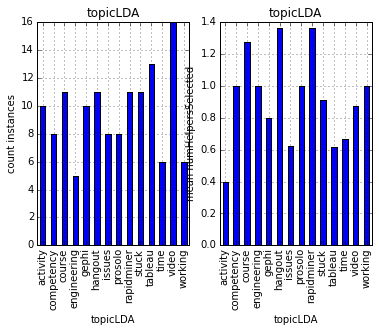



One-Way ANOVA: topicLDA --> numHelpersSelected
              df      sum_sq   mean_sq         F    PR(>F)
C(topicLDA)   13   11.036657  0.848974  0.559096  0.881792
Residual     120  182.217075  1.518476       NaN       NaN
                            OLS Regression Results                            
Dep. Variable:     numHelpersSelected   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                 -0.045
Method:                 Least Squares   F-statistic:                    0.5591
Date:                Sun, 26 Apr 2015   Prob (F-statistic):              0.882
Time:                        17:27:02   Log-Likelihood:                -210.73
No. Observations:                 134   AIC:                             449.5
Df Residuals:                     120   BIC:                             490.0
Df Model:                          13                                         
Covariance Type:            nonrobust                          

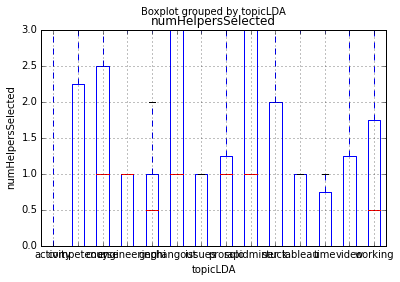

In [87]:
one_stats(data[[utils.COL_TOPIC]+conditions+[outcome]].dropna())

## Help Requests
Using naive coding, such as identifying if a question mark is included in the message (or the word 'question', or 'struggle' or 'stuck', etc) I identified which entries are most likely help requests and which are not. p = 0.002

TODO: should be a t-test, not ANOVA

count     134
unique      2
top         y
freq       89
Name: isHelpRequest, dtype: object


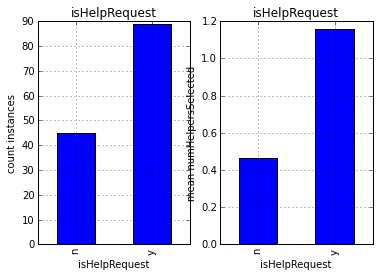



One-Way ANOVA: isHelpRequest --> numHelpersSelected
                   df      sum_sq    mean_sq          F    PR(>F)
C(isHelpRequest)    1   14.255979  14.255979  10.512921  0.001501
Residual          132  178.997753   1.356044        NaN       NaN
                            OLS Regression Results                            
Dep. Variable:     numHelpersSelected   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     10.51
Date:                Sun, 26 Apr 2015   Prob (F-statistic):            0.00150
Time:                        17:27:43   Log-Likelihood:                -209.54
No. Observations:                 134   AIC:                             423.1
Df Residuals:                     132   BIC:                             428.9
Df Model:                           1                                         
Covariance Type:            nonrobust

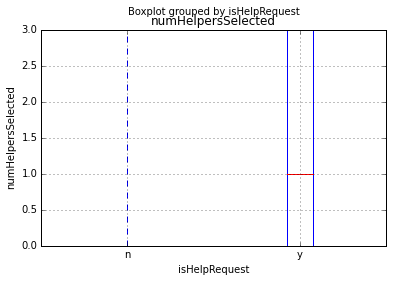

In [88]:
one_stats(data[[utils.COL_HELP_TOPIC]+conditions+[outcome]].dropna())

In [86]:
def one_stats(data_lastDV):
    """
    Do basic analysis of one IV onto one DV
    :param data: pandas dataframe we are exploring (IV-of-interest in first column, followed by IVs, and DV in last index)
    :return: None
    """
    col_names = data_lastDV.columns.values.tolist()  # get the columns' names
    causal = col_names.pop(0)  # first item is the topic
    outcome = col_names.pop()  # remove the last item in the list
    topic_data = data_lastDV[[causal, outcome]]

    # descriptive stats
    print(topic_data[causal].describe())

    fig = plt.figure()
    # bar chart of topics
    ax1 = fig.add_subplot(121)
    df_compare = topic_data.groupby(causal)[causal].count()  # displays num instances assigned to each condition
    ax1 = df_compare.plot(kind='bar', title=causal)
    ax1.set_xlabel(causal)
    ax1.set_ylabel("count instances")
    # scatter plot
    ax2 = fig.add_subplot(122)
    df_compare = data_lastDV.groupby(causal)[outcome].mean()  # displays num helpers selected in each topic
    ax2 = df_compare.plot(kind='bar', title=causal)
    ax2.set_xlabel(causal)
    ax2.set_ylabel("mean " + outcome)
    plt.show()

    # One Way ANOVA
    cond_lm = ols(outcome + " ~ C(" + causal + ")", data=topic_data).fit()
    anova_table = anova_lm(cond_lm)

    print("\n")
    print("One-Way ANOVA: " + causal + " --> " + outcome)
    print(anova_table)
    #print(cond_lm.model.data.orig_exog)
    print(cond_lm.summary())

    # boxplot of topics --> num helpers selected
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = topic_data.boxplot(outcome, causal, ax=plt.gca())
    ax.set_xlabel(causal)
    ax.set_ylabel(outcome)
    plt.show()

---
## Documentation
Find this project in [Github: UberHowley/MOOC-File-Processing](https://github.com/UberHowley/mooc-file-processing)

*This software was used for organizing data from the following experiment:*

[Howley, I., Tomar, G., Yang, D., Ferschke, O., & Rosé, C. (2015). Alleviating the negative effect of up and downvoting on help seeking in MOOC discussion forums. In Proceedings of 17th International Conference on Artificial Intelligence in Education (AIED 2015).](http://www.irishowley.com/website/pubs/2015howley_AlleviatingNegEffOfVotingInMOOCs.pdf)


